In [1]:
import numpy as np
from scipy.spatial import distance
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
filename = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/labeledcsv/CoBo_2018-06-20T10-51-39.459_0000.csv"
data_csv = pd.read_csv(filename, sep=',')

entry_nr = 25

singular_entry = data_csv[data_csv["entry_nr"]==entry_nr]


if singular_entry.empty:
    print("The value ", entry_nr, "s was not found in the 'entry_nr' column.")
else:
    print("The value ", entry_nr, " was found in the 'entry_nr' column.")

The value  25  was found in the 'entry_nr' column.


In [3]:
#functions

def hessian_distance(params, point):
    rho, theta = params
    x, y = point
    return np.abs(x * np.cos(theta) + y * np.sin(theta) - rho)

def objective(params, points):
    total_distance = 0
    for point in points:
        total_distance += hessian_distance(params, point)
    return total_distance

def line_distance3D(params, point):
    # https://www.nagwa.com/en/explainers/939127418581/
    # x0, y0, z0 is a point on the line
    # dx, dy, dz are the direction vector of the line
    x0, y0, z0, dx, dy, dz = params
    # Point coordinates
    x, y, z = point

    # Distance between our point and the point on the line.
    AP_x = x - x0
    AP_y = y - y0
    AP_z = z - z0

    # Cross product with the direction vector
    cp_x = AP_y * dz - AP_z * dy
    cp_y = AP_z * dx - AP_x * dz
    cp_z = AP_x * dy - AP_y * dx

    # Calculate the magnitude of the cross product
    mag_cp = np.sqrt( cp_x ** 2 + cp_y ** 2 + cp_z ** 2)

    # Calculate the magnitude of the direction vector
    mag_d = np.sqrt( dx ** 2 + dy ** 2 + dz ** 2)

    # The distance is the magnitude of the cross product over the magnitude of the direction vector
    distance = mag_cp / mag_d

    return distance
    

def objective3D(params, points):
    total_distance = 0
    for point in points:
        total_distance += line_distance3D(params, point)
    return total_distance

def findLambdaForPoint(x, x0, dx):
    lambda_val = (x - x0)/dx
    return lambda_val

rho: 100.44318445997449
theta: 0.32523051120269486


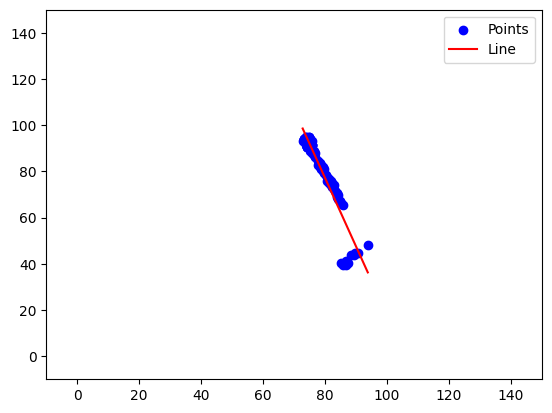

In [4]:
#1 line

points = singular_entry[['x', 'y']].to_numpy()




# Perform optimization
initial_guess = [0, 0]  # Initial guess for rho and theta
result = minimize(objective, initial_guess, args=(points,), method='BFGS')
rho, theta = result.x

print(f"rho: {rho}\ntheta: {theta}")

fig, ax = plt.subplots()

# Plot points
ax.scatter(points[:, 0], points[:, 1], color='blue', label='Points')
ax.set_xlim(-10, 150)
ax.set_ylim(-10, 150)


# Plot line(s)
x_vals = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
y_vals = (rho - x_vals * np.cos(theta)) / np.sin(theta)
ax.plot(x_vals, y_vals, color='red', label='Line')

ax.legend()
plt.show()


Line 1: y = -2.9655598436839106 * x + 314.3493815475177
Line 2: y = 1.083546521011807 * x + -53.557303563500255


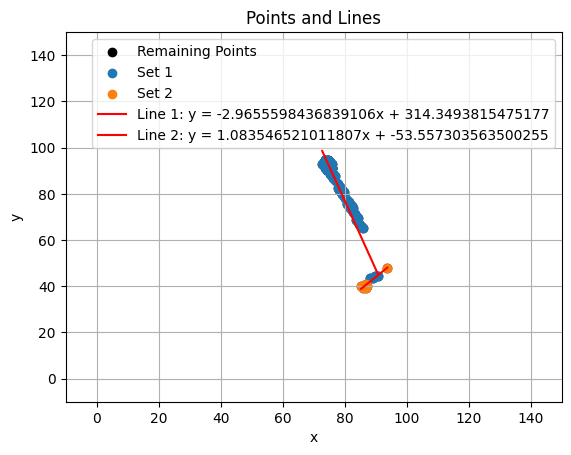

In [5]:
#more lines
nr_lines = 2000
distance_threshold = 3


plt.scatter(points[:, 0], points[:, 1], c='k', label='Remaining Points')

def detect_lines(points):
    lines = []
    set_points = []
    iter = 0
    while len(points) > 0 and iter < nr_lines:
        # Perform optimization
        initial_guess = [0, 0]  # Initial guess for rho and theta
        result = minimize(objective, initial_guess, args=(points,), method='BFGS')
        rho, theta = result.x

        # Calculate line equation
        m = -np.cos(theta) / np.sin(theta)  # Slope
        b = rho / np.sin(theta)             # Intercept
        line_equation = (m, b)
        lines.append(line_equation)

        # Remove points belonging to the detected line
        distances = [hessian_distance((rho, theta), point) for point in points]

        #the indices of the points to be removed
        points_to_remove = np.where(np.array(distances) <= distance_threshold)[0]

        #plt.scatter(points[points_to_remove, 0], points[points_to_remove, 1], label=f'Set {iter+1}')


        set_points.append(points[points_to_remove])
        points = np.delete(points, points_to_remove, axis=0)
        iter += 1

    #plt.scatter(points[:, 0], points[:, 1], c='k', label='Remaining Points')

    return lines, set_points

[line_params, set_points] = detect_lines(points)

for i, equation in enumerate(line_params):
    m, b = equation
    print(f"Line {i+1}: y = {m} * x + {b}")

#draw
for i, sets in enumerate(set_points):
    plt.scatter(sets[:, 0], sets[:, 1], label=f'Set {i+1}')




for i in range(len(line_params)):
    m, b = line_params[i]
    min_x = np.min(set_points[i][:, 0])
    max_x = np.max(set_points[i][:, 0])
    x = np.array([min_x, max_x])
    y = m * x + b
    plt.plot(x, y, c='r', label=f"Line {i+1}: y = {m}x + {b}")
    

#plt.plot(x, y, c='r', label=f"Line {i+1}: y = {m}x + {b}")
plt.xlim(-10, 150)
plt.ylim(-10, 150)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Points and Lines')
plt.grid(True)
plt.show()

[104.43094564  -2.77296388 -49.17920821  -0.28926233   0.93785119
   1.77097455]


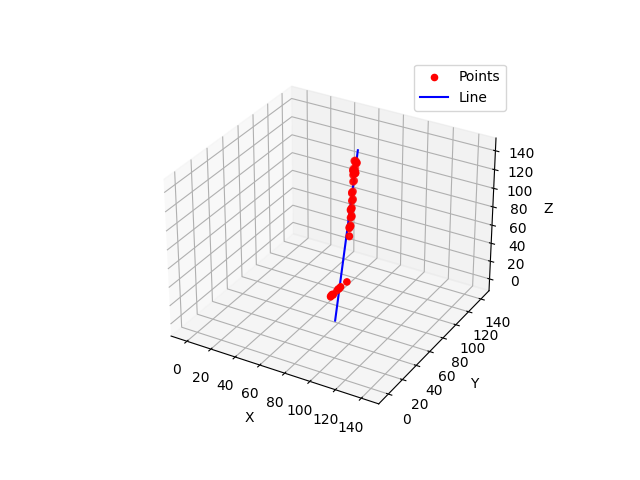

No such comm: 3b9b6c8f28904b05bdc7d99c42cb3799


In [6]:
#try 3d for 1 line
%matplotlib widget
points = singular_entry[['x', 'y', 'z']].to_numpy()

initial_guess3D = [0, 0, 0, 1, 1, 1]

result = minimize(objective3D, initial_guess3D, args=(points,), method='BFGS')

print(result.x)

x0, y0, z0, dx, dy, dz= result.x

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='red', label='Points')

# This t is the lambda scalar in r_vec = a_vec + lambda * d_vec and gives each point on the line.
# For now no idea how to select it.

min_val = np.min(points[:, 0])
max_val = np.max(points[:, 0])


lambda_min = findLambdaForPoint(min_val, x0, dx)
lambda_max = findLambdaForPoint(max_val, x0, dx)


t = np.linspace(lambda_min, lambda_max, 100)
line_points_x = x0 + t * dx
line_points_y = y0 + t * dy
line_points_z = z0 + t * dz
ax.plot(line_points_x, line_points_y, line_points_z, color='blue', label='Line')


ax.set_xlim(-10, 150)
ax.set_ylim(-10, 150)
ax.set_zlim(-10, 150)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()


Line 1: (104.43094563831815, -2.772963877378989, -49.179208205158574, -0.28926232794441953, 0.9378511911302542, 1.7709745464756865)
Line 2: (33.07957234193577, -17.024873449710295, -52.89889055148974, 3.5029418697239643, 3.756803609691322, 5.728115526094894)


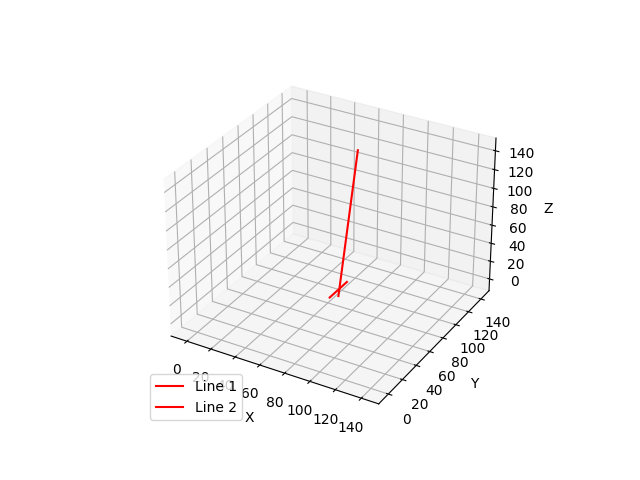

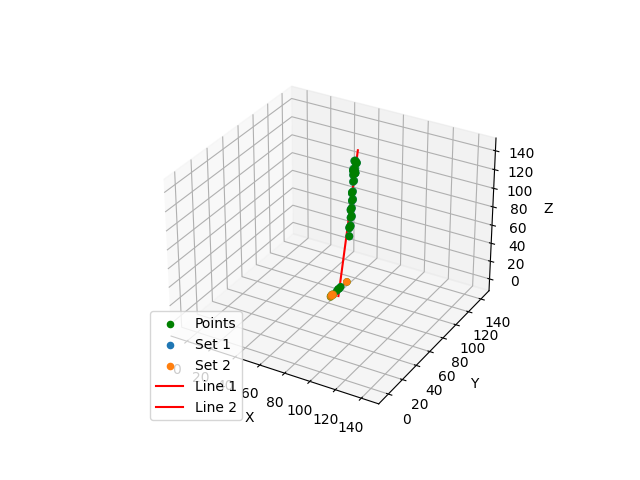

In [7]:
#try 3d for multiple lines

%matplotlib widget
points = singular_entry[['x', 'y', 'z']].to_numpy()

nr_lines = 2000
distance_threshold = 3.5

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='green', label='Points')


def detect_lines(points):
    lines = []
    set_points = []
    iter = 0
    while len(points) > 0 and iter < nr_lines:
        # Perform optimization
        initial_guess3D = [0, 0, 0, 1, 1, 1]
        result = minimize(objective3D, initial_guess3D, args=(points,), method='BFGS')
        x0, y0, z0, dx, dy, dz= result.x

        # Save them in this form for now
        line_params = (x0, y0, z0, dx, dy, dz)
        lines.append(line_params)

        # Remove points belonging to the detected line
        distances = [line_distance3D((x0, y0, z0, dx, dy, dz), point) for point in points]

        #the indices of the points to be removed
        points_to_remove = np.where(np.array(distances) <= distance_threshold)[0]




        set_points.append(points[points_to_remove])
        points = np.delete(points, points_to_remove, axis=0)
        iter += 1



    return lines, set_points

[line_params, set_points] = detect_lines(points)

for i, equation in enumerate(line_params):
    print(f"Line {i+1}: {equation}")

#draw
for i, sets in enumerate(set_points):
    ax.scatter(sets[:, 0], sets[:, 1], sets[:, 2], label=f'Set {i+1}')


fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')


for i in range(len(line_params)):
    x0, y0, z0, dx, dy, dz = line_params[i]

    min_x = np.min(set_points[i][:, 0])
    max_x = np.max(set_points[i][:, 0])
    lambda_min = findLambdaForPoint(min_x, x0, dx)
    lambda_max = findLambdaForPoint(max_x, x0, dx)
    

    t = np.linspace(lambda_min, lambda_max, 100)
    line_points_x = x0 + t * dx
    line_points_y = y0 + t * dy
    line_points_z = z0 + t * dz
    ax.plot(line_points_x, line_points_y, line_points_z, color='r', label=f"Line {i+1}")
    ax2.plot(line_points_x, line_points_y, line_points_z, color='r', label=f"Line {i+1}")





ax.set_xlim(-10, 150)
ax.set_ylim(-10, 150)
ax.set_zlim(-10, 150)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(loc='lower left')







ax2.set_xlim(-10, 150)
ax2.set_ylim(-10, 150)
ax2.set_zlim(-10, 150)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend(loc='lower left')




plt.show()




